# Intro to Logistic Regression in PyTorch

In this notebook, we're going to build a very simple neural network in PyTorch to do handwritten digit classification.
First, we'll start with some exploration of the MNIST dataset, explaining how we load and format the data.
We'll then jump into motivating and then implementing the logistic regression model, including the forward and backwards pass, loss functions, and optimizers.
After training the model, we'll evaluate how we did and visualize what we've learned.
Finally, we'll refactor our code in an object-oriented manner, using higher level APIs.

Before we get started, some imports for the packages we'll be using:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

### MNIST Dataset

The MNIST dataset is very popular machine learning dataset, consisting of 70000 grayscale images of handwritten digits, of dimensions 28x28. 
We'll be using it as our example dataset for this section of the tutorial, with the goal being to predict which digit is in each image.

![mnist](Figures/mnist.png)

The first (and often most important) step in machine learning is preparing the data.
This can include downloading, organizing, formatting, shuffling, pre-processing, augmenting, and batching examples so that they can be fed to a model.
The `torchvision` package makes this easy by implementing many of these, allowing us to put these datasets into a usable form in only a few lines of code.
First, let's download the train and test sets of MNIST:

In [2]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

In [3]:
print("Number of MNIST training examples: {}".format(len(mnist_train)))
print("Number of MNIST test examples: {}".format(len(mnist_test)))

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000


As we'd expect, 60000 of the MNIST examples are in the train set, and the rest are in the test set.
We added the transform `ToTensor()` when formatting the dataset, to convert the input data from a Pillow `Image` type into a PyTorch `Tensor`. Tensors will eventually be the input type that we feed into our model. 

Let's look at an example image from the train set and its label.
Notice that the `image` tensor defaults to something 3-dimensional.
The "1" in the first dimension indicates that the image only has one channel (i.e. grayscale).
We need to get rid of this to visualize the image with `imshow`.

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


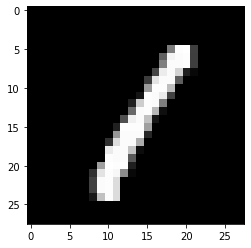

In [4]:
# Pick out the 4th (0-indexed) example from the training set
image, label = mnist_train[3]

# Plot the image
print("Default image shape: {}".format(image.shape))
image = image.reshape([28,28])
print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap="gray")

# Print the label
print("The label for this image: {}".format(label))

While we could work directly with the data as a `torchvision.dataset`, we'll find it useful to use a `DataLoader`, which will take care of shuffling and batching:

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [6]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


### Logistic Regression Model

Now that we have a good feel for how to load our data, let's start putting together our model. 
In this tutorial, we'll be building a logistic regression model, which is essentially a fully-connected neural network without any hidden layers. 
While fairly basic, logistic regression can perform surprisingly well on many simple classification tasks.

#### The forward pass

While our data inputs (which we'll call `x`) are images (i.e. 2-dimensional), MNIST digits are pretty small, and the model we're using is very simple.
Thus, we're going to be treating the input as flat vectors.
To convert our inputs into row vectors (a.k.a. flattening), we can use `view()`, the equivalent of NumPy's `reshape()`.
Also like NumPy, we can replace one of the dimensions of the reshaping with a `-1`, which tells PyTorch to infer this dimension based on the original dimensions and the other specified dimensions.
Let's do try this flattening on the minibatch of 100 images we drew in the previous section.

In [8]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))# cambio las matrices de 28x28 por vectores
# de 784

The shape of input x: torch.Size([100, 784])


In [10]:
images

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [11]:
# Randomly initialize weights W
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

In [16]:
W.shape

torch.Size([784, 10])

As both `W` and `b` are parameters we wish to learn, we set `requires_grad` to `True`. 
This tells PyTorch's autograd to track the gradients for these two variables, and all the variables depending on `W` and `b`.

With these model parameters, we compute $y$:

In [17]:
# Linear transformation with W and b
y = torch.matmul(x, W) + b

We can see for example what the predictions look like for the first example in our minibatch. Remember, the bigger the number, the more the model thinks the input $x$ is of that class.

In [30]:
print(y[0,:])

tensor([ 0.3128,  0.1433,  0.0745, -0.0265, -0.0025, -0.0903, -0.2322, -0.6388,
         0.3499,  0.2201], grad_fn=<SliceBackward>)


Convert values to probabilities

In [31]:
# Option 1: Softmax to probabilities from equation
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

# Option 2: Softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py[0]))

py[0] from equation: tensor([0.1306, 0.1102, 0.1029, 0.0930, 0.0953, 0.0873, 0.0757, 0.0504, 0.1355,
        0.1190], grad_fn=<SelectBackward>)
py[0] with torch.nn.functional.softmax: tensor([0.1306, 0.1102, 0.1029, 0.0930, 0.0953, 0.0873, 0.0757, 0.0504, 0.1355,
        0.1190], grad_fn=<SelectBackward>)


We've now defined the forward pass of our model: given an input image, the graph returns the probabilities the model thinks the input is each of the 10 classes. Are we done?